In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
)
from tensorflow.keras import layers, models
import keras
import tensorflow as tf

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:

# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [4]:
# Copy the kaggle.json to the appropriate location
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"riwaj111111","key":"4f87d63a52c5d0f05857576ffd2abe2e"}'}

In [5]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

In [6]:
!kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 98% 146M/149M [00:01<00:00, 128MB/s]
100% 149M/149M [00:01<00:00, 87.4MB/s]


In [7]:
train_dir = "/content/Training/"
test_dir = "/content/Testing/"

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and parameters
image_shape = (224, 224)  # Resize all images to 224x224
batch_size = 64  # Batch size for loading data

# Set a seed for consistent random splitting
seed_value = 42

# Initialize ImageDataGenerator for training/validation and test
train_valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    validation_split=0.2  # 20% of the training data for validation
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only rescaling for test data

# Create training data generator (80% of the total dataset, shuffled randomly)
print("Training Images:")
train_data = train_valid_datagen.flow_from_directory(
    "/content/Training/",
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,  # Ensure randomization
    subset='training',  # Specify the training subset (80% of total)
    seed=seed_value  # Set seed for reproducibility
)

# Create validation data generator (20% of the total dataset, shuffled randomly)
print("Validating Images:")
valid_data = train_valid_datagen.flow_from_directory(
    "/content/Training/",
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,  # No need to shuffle validation data
    subset='validation',  # Specify the validation subset (20% of total)
    seed=seed_value  # Set seed for reproducibility
)

# Create test data generator (randomized based on file order)
print("Test Images:")
test_data = test_datagen.flow_from_directory(
    "/content/Testing/",
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No need to shuffle test data
)


Training Images:
Found 4571 images belonging to 4 classes.
Validating Images:
Found 1141 images belonging to 4 classes.
Test Images:
Found 1311 images belonging to 4 classes.


In [19]:

# Extract class names from the datasets using class_indices
train_class_names = list(train_data.class_indices.keys())
valid_class_names = list(valid_data.class_indices.keys())
test_class_names = list(test_data.class_indices.keys())

# Print class names
print("Training Class Names:", train_class_names)
print("Validation Class Names:", valid_class_names)
print("Test Class Names:", test_class_names)

# Print the number of classes
print("Number of Training Classes:", len(train_class_names))
print("Number of Validation Classes:", len(valid_class_names))
print("Number of Test Classes:", len(test_class_names))

Training Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Validation Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Test Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Number of Training Classes: 4
Number of Validation Classes: 4
Number of Test Classes: 4


In [20]:
class_names = train_class_names


In [21]:
from collections import Counter
print(Counter(train_data.classes))  # Check class distribution in training data
print(Counter(valid_data.classes))  # Check class distribution in validation data
print(Counter(test_data.classes))   # Check class distribution in test data


Counter({2: 1276, 3: 1166, 1: 1072, 0: 1057})
Counter({2: 319, 3: 291, 1: 267, 0: 264})
Counter({2: 405, 1: 306, 0: 300, 3: 300})


In [33]:
model = Sequential()
model.add(keras.layers.InputLayer(input_shape=(224, 224, 3)))
model.add(Conv2D(16,(3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32,(3,3), activation="relu"))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation='sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [34]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      47,776,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,783,396 (182.28 MB)

 Trainable params: 47,783,396 (182.28 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [36]:
# 13. Learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-7
)

In [37]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)


In [ ]:
history = model.fit(train_data,
                    verbose=1,
                    epochs=25,
                    validation_data=valid_data,
                    callbacks = [lr_scheduler, early_stopping]
)

Epoch 1/25


In [28]:
model.save("brain_tumor_classification.keras")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 
Image 1: Predicted incorrectly. True: glioma, Pred: pituitary
Image 2: Predicted correctly: glioma
Image 3: Predicted correctly: glioma
Image 4: Predicted incorrectly. True: glioma, Pred: pituitary
Image 5: Predicted correctly: glioma


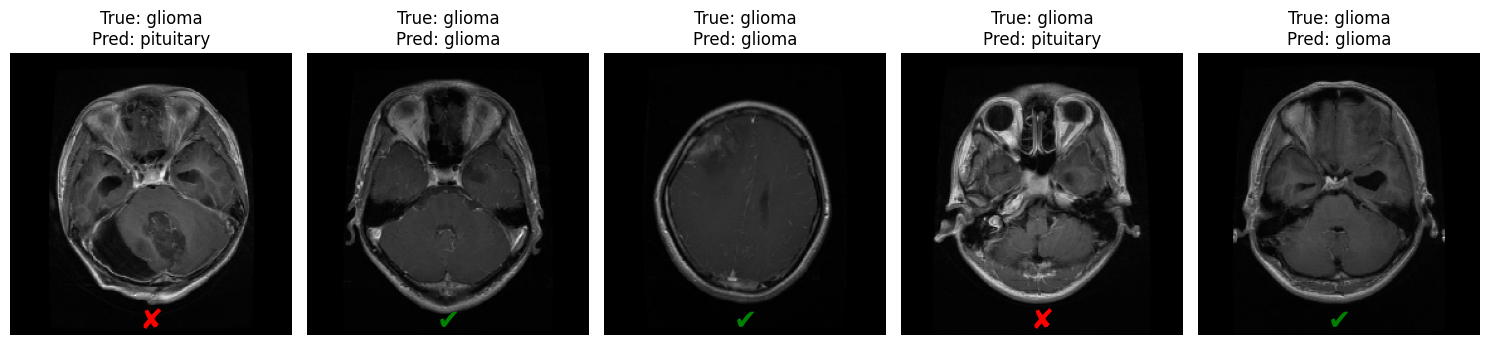

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Assuming `test_data` is the test data generator with images and labels
# Assuming `model` is the trained model

# Fetch the first 5 images and their true labels from the test data
test_images, test_labels = next(test_data)  # Get the first batch of images and labels

# Convert the one-hot encoded labels to class indices
test_labels_classes = np.argmax(test_labels, axis=1)

# Predict on these images
Y_pred = model.predict(test_images)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Get the class names (assuming you have these from the validation data or training)
class_names = list(test_data.class_indices.keys())

# Set up a subplot with 1 row and 5 columns
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Plot the first 5 images along with the predicted and true labels
for i in range(5):
    axes[i].imshow(test_images[i])  # Display image
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f'True: {class_names[test_labels_classes[i]]}\nPred: {class_names[Y_pred_classes[i]]}')

    # Check if the predicted label matches the true label
    if test_labels_classes[i] == Y_pred_classes[i]:
        # Display a green tick (✔) for correct prediction
        axes[i].text(0.5, 0.05, '✔', fontsize=20, color='green', ha='center', va='center', transform=axes[i].transAxes)
        print(f'Image {i+1}: Predicted correctly: {class_names[test_labels_classes[i]]}')
    else:
        # Display a red cross (✘) for incorrect prediction
        axes[i].text(0.5, 0.05, '✘', fontsize=20, color='red', ha='center', va='center', transform=axes[i].transAxes)
        print(f'Image {i+1}: Predicted incorrectly. True: {class_names[test_labels_classes[i]]}, Pred: {class_names[Y_pred_classes[i]]}')

plt.tight_layout()
plt.show()


# Training and Evaluation


In [30]:
Y_pred = model.predict(test_data)
score = model.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.6372 - loss: 1.1011
Test loss: 0.9518227577209473
Test accuracy: 0.6704805493354797


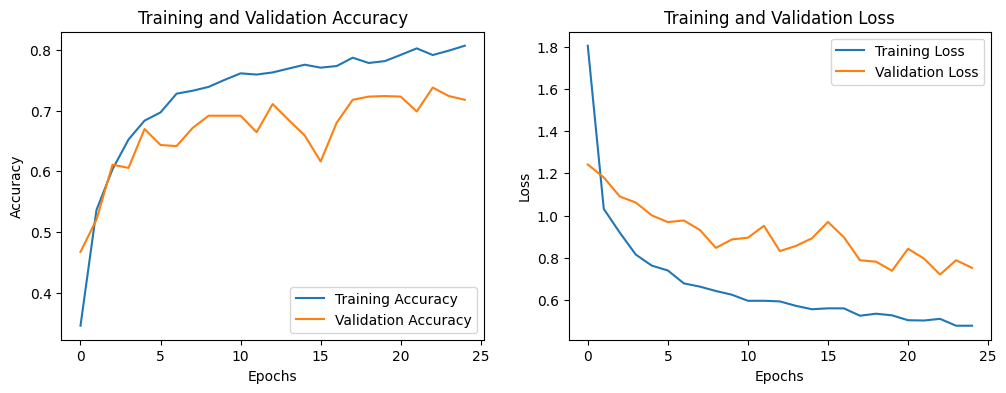

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

# Define class names (replace these with actual class names if available)
CLASS_NAMES = class_names

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)

18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 801ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.83      0.78      0.80       264
  meningioma       0.56      0.58      0.57       267
     notumor       0.77      0.84      0.80       319
   pituitary       0.78      0.73      0.75       291

    accuracy                           0.74      1141
   macro avg       0.74      0.73      0.73      1141
weighted avg       0.74      0.74      0.74      1141

Precision: 0.74, Recall: 0.74, F1 Score: 0.74


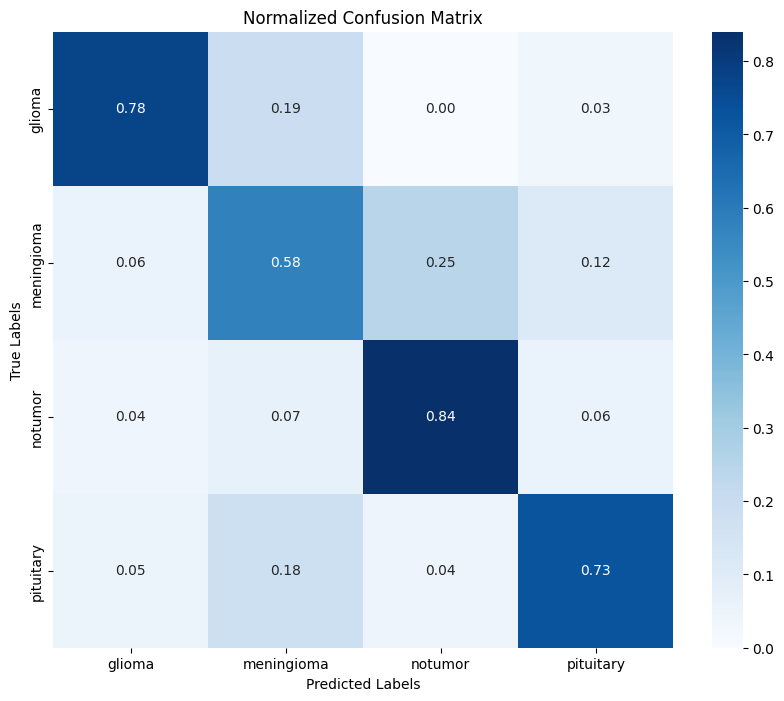

In [32]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Predict on validation data
Y_pred = model.predict(valid_data)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = valid_data.classes  # Actual class labels from validation data

# Generate a classification report
CLASS_NAMES = list(valid_data.class_indices.keys())  # Extract class names from validation data generator
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes, target_names=class_names))

# Calculate precision, recall, and F1-score
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

# Calculate normalized confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# GUI Implementation


In [ ]:
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import tensorflow as tf

# Load your pre-trained model
model = model  # Assuming your model is already loaded

# Define class names
CLASS_NAMES = class_names  # Use your actual class names here

# Function to preprocess and predict the image
def predict_image(img):
    img_resized = img.resize((224, 224))
    img_array = np.array(img_resized) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict and get confidence score
    predictions = model.predict(img_array)
    confidence_scores = predictions[0]
    pred_index = np.argmax(confidence_scores)
    pred_class = class_names[pred_index]
    pred_confidence = confidence_scores[pred_index]

    result_label.value = f"Prediction: {pred_class}\nConfidence: {pred_confidence:.2f}"

# Define widgets
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
result_label = widgets.Label()

# Display the uploaded image and perform prediction
def on_upload_change(change):
    # Clear previous output (remove old image and result)
    clear_output(wait=True)

    # Re-display the upload button and result label
    display(widgets.VBox([upload_button, result_label]))

    for name, file_info in upload_button.value.items():
        image_data = io.BytesIO(file_info['content'])  # Convert binary content to a BytesIO object
        image = Image.open(image_data)  # Open image with PIL
        display(image)  # Display the uploaded image in the notebook
        predict_image(image)

upload_button.observe(on_upload_change, names='value')

# Display widgets
display(widgets.VBox([upload_button, result_label]))